In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def scaling_law_fn(N, a, alpha, b):
    """
    L(N) = a * N^{-alpha} + b

    N is number of tokens (can be rescaled to billions).
    """
    N = np.asarray(N, dtype=np.float64)
    # Use exp(-alpha * log N) for numerical stability
    return a * np.exp(-alpha * np.log(N)) + b


def fit_scaling_law(tokens,
                    losses,
                    min_tokens=None,
                    max_tokens=None,
                    tokens_scale=1e9):
    """
    Fit L(N) ≈ a N^{-alpha} + b on a subset of (tokens, losses).

    tokens: 1D array of token counts
    losses: 1D array of validation losses (same length)
    min_tokens, max_tokens: optional range of tokens to use for the fit
    tokens_scale: divide tokens by this before fitting (e.g. 1e9 for billions)

    Returns: (params, cov, fit_tokens, fit_losses, fitted_curve_tokens, fitted_curve_losses)
        params = (a, alpha, b)
    """
    tokens = np.asarray(tokens, dtype=np.float64)
    losses = np.asarray(losses, dtype=np.float64)

    mask = np.isfinite(tokens) & np.isfinite(losses) & (tokens > 0)
    if min_tokens is not None:
        mask &= (tokens >= min_tokens)
    if max_tokens is not None:
        mask &= (tokens <= max_tokens)

    tokens_fit = tokens[mask] / tokens_scale
    losses_fit = losses[mask]

    if tokens_fit.size < 3:
        raise ValueError("Not enough points after masking for a 3‑parameter fit.")

    # Initial guesses:
    # - a: scale of (L - min(L)) * N^{alpha_guess}
    # - alpha: small positive exponent
    # - b: near min loss in the fit window
    alpha_guess = 0.1
    b_guess = float(losses_fit.min())
    a_guess = float((losses_fit.max() - b_guess) * tokens_fit[0]**alpha_guess)

    p0 = [a_guess, alpha_guess, b_guess]
    bounds = ([0.0, 0.0, -np.inf], [np.inf, 1.0, np.inf])

    params, cov = curve_fit(
        scaling_law_fn,
        tokens_fit,
        losses_fit,
        p0=p0,
        bounds=bounds,
        maxfev=20000,
    )

    a_hat, alpha_hat, b_hat = params

    # smooth curve over the fit region
    N_min = tokens_fit.min()
    N_max = tokens_fit.max()
    N_curve = np.linspace(N_min, N_max, 200)
    L_curve = scaling_law_fn(N_curve, a_hat, alpha_hat, b_hat)

    return params, cov, tokens_fit, losses_fit, N_curve, L_curve


In [42]:

prior_path = "/Users/jonathanmiddleton/Downloads/wandb_export_milli-dclm-run1.csv"          # prior run
current_path = "/Users/jonathanmiddleton/Downloads/wandb_export_2025-12-01T21_29_22.614-05_00.csv"  # first part of current run

df_prior = pd.read_csv(prior_path)
df_current = pd.read_csv(current_path)

def pick_val_col(df):
    candidates = [c for c in df.columns if "val/loss" in c]
    if not candidates:
        raise ValueError(f"No 'val/loss' column found in {df.columns}")
    return candidates[0]

val_col_prior = pick_val_col(df_prior)
val_col_current = pick_val_col(df_current)

print("Prior val column:", val_col_prior)
print("Current val column:", val_col_current)

tokens_prior = df_prior["tokens"].values
loss_prior = df_prior[val_col_prior].values

tokens_current = df_current["tokens"].values
loss_current = df_current[val_col_current].values


Prior val column: milli-dclm - val/loss
Current val column: val/loss


In [43]:
# window you want to fit on
min_tokens = 3e8    # ignore very early noisy points
max_tokens = 1.7e10    # "early" part of the run

params_prior, cov_prior, N_fit_prior, L_fit_prior, N_curve_prior, L_curve_prior = fit_scaling_law(
    tokens_prior,
    loss_prior,
    min_tokens=min_tokens,
    max_tokens=max_tokens,
    tokens_scale=1e9,   # work in billions of tokens
)

a_p, alpha_p, b_p = params_prior
print("=== Prior run fit (billions of tokens) ===")
print(f"a      = {a_p:.4e}")
print(f"alpha  = {alpha_p:.6f}")
print(f"b (floor) = {b_p:.6f}")
print(f"fitted on {len(N_fit_prior)} points, N in [{N_fit_prior.min():.3f}, {N_fit_prior.max():.3f}] B tokens")


=== Prior run fit (billions of tokens) ===
a      = 4.2240e-01
alpha  = 0.501368
b (floor) = 2.752024
fitted on 252 points, N in [0.328, 16.778] B tokens


In [44]:
params_curr, cov_curr, N_fit_curr, L_fit_curr, N_curve_curr, L_curve_curr = fit_scaling_law(
    tokens_current,
    loss_current,
    min_tokens=min_tokens,
    max_tokens=max_tokens,
    tokens_scale=1e9,
)

a_c, alpha_c, b_c = params_curr
print("\n=== Current run fit (billions of tokens) ===")
print(f"a      = {a_c:.4e}")
print(f"alpha  = {alpha_c:.6f}")
print(f"b (floor) = {b_c:.6f}")
print(f"fitted on {len(N_fit_curr)} points, N in [{N_fit_curr.min():.3f}, {N_fit_curr.max():.3f}] B tokens")



=== Current run fit (billions of tokens) ===
a      = 1.0008e+00
alpha  = 0.244990
b (floor) = 2.155315
fitted on 57 points, N in [0.328, 3.998] B tokens


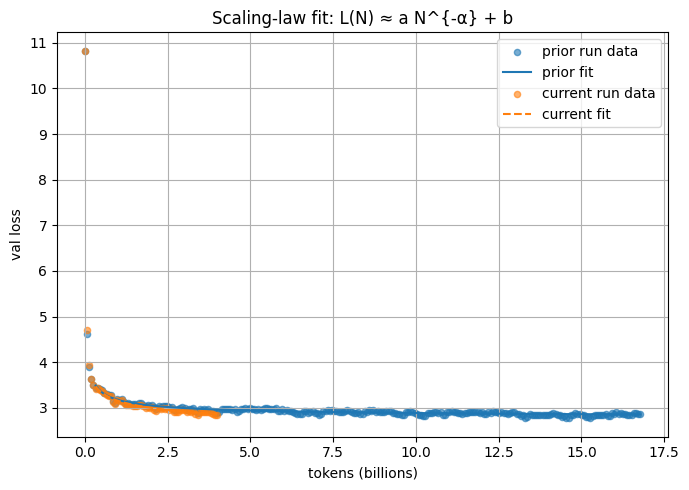

In [45]:
plt.figure(figsize=(7, 5))

# Prior run: scatter + fit
plt.scatter(tokens_prior / 1e9, loss_prior, s=20, alpha=0.6, label="prior run data")
plt.plot(N_curve_prior, L_curve_prior, linestyle="-", label="prior fit")

# Current run: scatter + fit (optional)
plt.scatter(tokens_current / 1e9, loss_current, s=20, alpha=0.6, label="current run data")
plt.plot(N_curve_curr, L_curve_curr, linestyle="--", label="current fit")

plt.xlabel("tokens (billions)")
plt.ylabel("val loss")
plt.title("Scaling-law fit: L(N) ≈ a N^{-α} + b")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
